# Make opto vs ctrl mean FR scatter plot

In [1]:
run -im djd.main -- --dbname=dj_hmov

Connecting write@huxley.neuro.bzm:3306
Connected to database 'dj_hmov' as 'write@10.153.173.165'


In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
# warnings.filterwarnings("ignore")

# DJD modules
from djd.hmov_unit import plot_fr_scatter
from djd.plot import get_color_dict
from .const import CRIT

In [3]:
%load_ext autoreload
%autoreload 2

## TODO
- statistical test: Wilcoxon/Mann-Whitney-U (indep) <> Wilcoxon signed-rank (paired)
- plot mean as cross?
- plot regression and significance?

## Get mean FRs opto vs control

In [11]:
df = pd.DataFrame((HmovUnit() & f'hmu_fr_mean_e > {CRIT["fr_crit"]}'
                  ).fetch(dj.key, 'hmu_fr_mean_stim_ctrl', 'hmu_fr_mean_stim_opto', 'hmu_fr_mean_spont_ctrl', 'hmu_fr_mean_spont_opto',
                          as_dict=True))
df

,m,s,e,u,hmu_fr_mean_stim_ctrl,hmu_fr_mean_stim_opto,hmu_fr_mean_spont_ctrl,hmu_fr_mean_spont_opto
0,Ntsr1Cre_2019_0007,6,9,1,3.134990,3.240050,2.999480,3.143790
1,Ntsr1Cre_2019_0007,6,9,2,0.270756,0.356787,0.331958,0.620805
2,Ntsr1Cre_2019_0007,6,9,3,0.717029,0.713503,0.347370,0.647965
3,Ntsr1Cre_2019_0007,6,9,4,0.192709,0.246167,0.260824,0.471424
4,Ntsr1Cre_2019_0007,6,9,5,0.502309,0.467831,0.426803,0.561634
...,...,...,...,...,...,...,...,...
147,Ntsr1Cre_2020_0002,6,6,28,20.349600,22.002700,4.404080,4.167640
148,Ntsr1Cre_2020_0002,6,6,30,15.117300,14.304700,13.437800,14.356100
149,Ntsr1Cre_2020_0002,6,6,33,19.642300,18.665800,21.486200,20.665300
150,Ntsr1Cre_2020_0002,6,6,38,14.568300,13.189800,13.764200,12.294100


## Plot scatter plot

In [5]:
## Update plot parameters
# Option 1: Update general pars from modified matplotlibrc file
plt.rcParams.update(mpl.rc_params_from_file('../../matplotlibrc', fail_on_error=False, use_default_template=True))

# Option 2: Dynamically update general pars (use if not updating from modified matplotlibrc)
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.labelsize': 'medium',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    'ps.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    })

# Dynamically update plot-specific pars
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
#     'ytick.major.pad': 1, # 3.5
    'axes.labelsize': 7.0,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    })

# Get default colors for opto, locomotion and eye data
col_dict = get_color_dict(color_names=['blue','orange', 'green', 'red', 'purple',
                                       'brown', 'pink', 'gray', 'yellow', 'lightblue'])
col = col_dict['blue']  # opto color

In [ ]:
fig, ax = plot_fr_scatter(frs_sit, frs_run, labels=['Sit', 'Run'],
                        logscale=False, axlims=[0, 40], axticks=[0.1,1,10,100], adjust_sp=True, 
                        facecolor=col, edgecolor='none', alpha=0.4, size=7, figsize=(3.5,3.5), dpi=300)
plt.savefig('locomotion_fr_scatter.pdf')

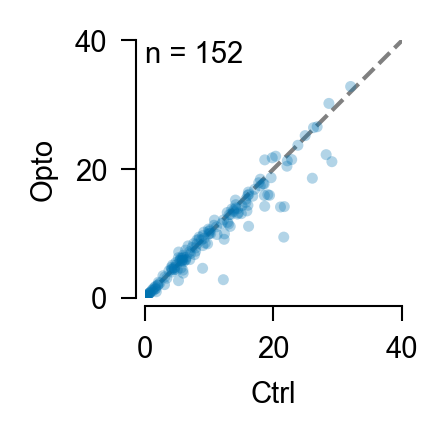

In [12]:
fig, ax = plot_fr_scatter(df['hmu_fr_mean_stim_ctrl'], df['hmu_fr_mean_stim_opto'], labels=['Ctrl', 'Opto'],
                        title=False, logscale=False, axlims=[0, 40], axticks=[0.1,1,10,100],
                        facecolor=col, edgecolor='none', alpha=0.3, size=7, figsize=(3.5,3.5), dpi=300)
plt.savefig('opto_fr_scatter.pdf')

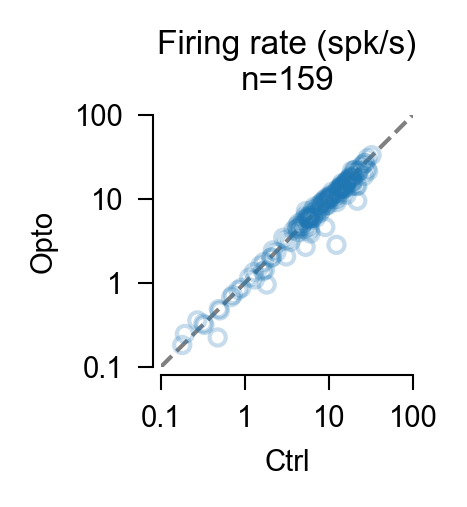

In [40]:
fig, ax = plot_fr_scatter(df['hmu_fr_mean_stim_ctrl'], df['hmu_fr_mean_stim_opto'], labels=['Ctrl', 'Opto'], color='tab:blue',
                        logscale=True, axlims=[0.1, 100], axticks=[0.1,1,10,100], dpi=300, size=15)
# plt.savefig('opto_fr_scatter.pdf')

## Stats tests

In [53]:
# Perform statistical significance test
# Given that we sample two values from each neuron (ctrl vs opto) and mean FRs in each condition will be dependent on the neuron
# (high FR neurons will likely have high FRs both in ctrl and opto), and given that FRs are likely not normally distributed (but log-normally),
# the Wilcoxon rank signed rank test seems most appropriate

print('Mean FRs contrl vs opto:')

# Wilcoxon signed rank: non-parametric, paired samples
from scipy.stats import wilcoxon
print(wilcoxon(df['hmu_fr_mean_stim_ctrl'], df['hmu_fr_mean_stim_opto']))

# Mann-Whitney U / Mann–Whitney–Wilcoxon (MWW) / Wilcoxon rank-sum test: non-parametric, independent samples
from scipy.stats import mannwhitneyu
print(mannwhitneyu(df['hmu_fr_mean_stim_ctrl'], df['hmu_fr_mean_stim_opto']))#, alternative='less'))

# T-test rel: parametric, paired samples
from scipy.stats import ttest_rel
print(ttest_rel(df['hmu_fr_mean_stim_ctrl'], df['hmu_fr_mean_stim_opto']))

# T-test ind: parametric, independent samples
from scipy.stats import ttest_ind
print(ttest_ind(df['hmu_fr_mean_stim_ctrl'], df['hmu_fr_mean_stim_opto']))

Mean FRs contrl vs opto:
WilcoxonResult(statistic=4547.0, pvalue=0.0018220073478929324)
MannwhitneyuResult(statistic=12133.0, pvalue=0.2681385641372424)
Ttest_relResult(statistic=4.0104000069370915, pvalue=9.326619519521796e-05)
Ttest_indResult(statistic=0.7839170437373971, pvalue=0.43367598092198256)
